In [195]:
import numpy as np
import astropy
from astropy.table import Table, join, vstack, hstack, Column
from astropy import stats as apstats
from tqdm import tqdm_notebook
import hastrofunc as hastro
from scipy import stats
from scipy.stats import norm
import imp
import glob
from datetime import datetime
import os

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set_theme(style="ticks", color_codes=True)

AttributeError: module 'seaborn' has no attribute 'set_theme'

In [179]:
runs = Table(names=["model","ion","hvc_flag","RMS","R_squared",\
                    "vflat","vflat_err_lower","vflat_err_upper",\
                    "lag","lag_err_lower","lag_err_upper",\
                    "vz","vz_err_lower","vz_err_upper",\
                    "h0","h0_err_lower","h0_err_upper",\
                    "sigma","sigma_err_lower","sigma_err_upper",\
                    "R0","R0_err_lower","R0_err_upper"\
                   ],
            dtype=['<U40', '<U7', 'U','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f',
                  'f','f','f'])


In [180]:
models = ['FlatSandwich','GaussianSandwich','RadialVerticalExponential','VerticalExponential']
ions = ['CIV', 'SiIV', 'CII*', 'SiII', 'SII', 'FeII', 'NiII', 'NV']
hvc_flag = ['3']

In [181]:
runs[runs["ion"] == 'SII']

model,ion,hvc_flag,RMS,R_squared,vflat,vflat_err_lower,vflat_err_upper,lag,lag_err_lower,lag_err_upper,vz,vz_err_lower,vz_err_upper,h0,h0_err_lower,h0_err_upper,sigma,sigma_err_lower,sigma_err_upper,R0,R0_err_lower,R0_err_upper
str40,str7,str1,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32


In [182]:
!pwd
os.getcwd()

/Users/hannahbish/Dropbox/QuaStar/DHmodels


'/Users/hannahbish/Dropbox/QuaStar/DHmodels'

In [183]:
test = Table.read(os.getcwd()+'/runs/hvc_flag_3/FlatSandwich/params_FlatSandwich_NV.txt',format='ascii')

In [184]:
test

col1,col2,col3,col4
str9,float64,float64,float64
vflat,217.047,-0.216,0.231
lag,10.016,-2.049,2.025
vz,-13.328,-0.142,0.143
h0,0.043,-0.007,0.007
R_squared,0.196,-999.0,-999.0
RMS,29.074,-999.0,-999.0


In [185]:
# Load FlatSandwich results
for model in models:
    print(model)
    for ion in ions:
        print(ion)
        for hflag in hvc_flag:
            runs.add_row(vals=['-999']*len(runs.colnames))
            runs[-1]['model'],runs[-1]['ion'],runs[-1]['hvc_flag'] = model, ion, hflag # Add model, ion, and HVC flag of this run to the row of the table you just added
            temp = Table.read(os.getcwd()+'/runs/hvc_flag_'+hflag+'/'+model+'/params_'+model+'_'+ion+'.txt',format='ascii') # Read in output file
            for row in temp:
                param = row[0]
                runs[-1][param] = row[1] # parameter value
                if (param != 'RMS') & (param != 'R_squared'):
                    runs[-1][param+'_err_lower'] = str(row[2])[1:] # parameter lower error
                    runs[-1][param+'_err_upper'] = str(row[3])[1:] # parameter upper error
                
#                 print(row[0])
                

FlatSandwich
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV
GaussianSandwich
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV
RadialVerticalExponential
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV
VerticalExponential
CIV
SiIV
CII*
SiII
SII
FeII
NiII
NV


In [186]:
print(runs[runs['model'] == 'FlatSandwich'])

   model     ion  hvc_flag  RMS   ...   R0   R0_err_lower R0_err_upper
------------ ---- -------- ------ ... ------ ------------ ------------
FlatSandwich  CIV        3 25.228 ... -999.0       -999.0       -999.0
FlatSandwich SiIV        3 25.026 ... -999.0       -999.0       -999.0
FlatSandwich CII*        3  16.72 ... -999.0       -999.0       -999.0
FlatSandwich SiII        3 16.055 ... -999.0       -999.0       -999.0
FlatSandwich  SII        3 13.033 ... -999.0       -999.0       -999.0
FlatSandwich FeII        3  47.33 ... -999.0       -999.0       -999.0
FlatSandwich NiII        3 17.737 ... -999.0       -999.0       -999.0
FlatSandwich   NV        3 29.074 ... -999.0       -999.0       -999.0


In [187]:
for ion in ions:
    best_R2 = max(runs['R_squared'][runs['ion'] == ion])
    best_RMS = min(runs['RMS'][runs['ion'] == ion])
    best_model = runs['model'][(runs['ion'] == ion) & (runs['RMS'] == best_RMS)]
    if len(best_model) > 1:
        print(ion,'\t',"Tie between:", [m for m in best_model])
    else:
        print(ion,'\t',runs['model'][(runs['ion'] == ion) & (runs['RMS'] == best_RMS)][0])
#     print(ion,"\t Max R^2 = ",best_R2,"\t Best model = ",best_model)

CIV 	 Tie between: ['FlatSandwich', 'GaussianSandwich', 'RadialVerticalExponential']
SiIV 	 Tie between: ['FlatSandwich', 'GaussianSandwich']
CII* 	 RadialVerticalExponential
SiII 	 RadialVerticalExponential
SII 	 RadialVerticalExponential
FeII 	 GaussianSandwich
NiII 	 RadialVerticalExponential
NV 	 FlatSandwich


In [188]:
# runs['model'][(runs['ion'] == ion) & (runs['R_squared'] == best_R2)]
np.where(runs['R_squared'][runs['ion'] == ion] == max(runs['R_squared'][runs['ion'] == ion]))

(array([0, 1, 2, 3]),)

In [189]:
runs['model'][runs['ion'] == 'CIV'], runs['R_squared'][runs['ion'] == 'CIV']

(<Column name='model' dtype='str40' length=4>
              FlatSandwich
          GaussianSandwich
 RadialVerticalExponential
       VerticalExponential, <Column name='R_squared' dtype='float32' length=4>
 0.234
 0.234
 0.234
 0.234)

In [194]:
table_param = 'RMS'

print('\t','FlatSand','\t\t','GaussSand','\t\t','RadVertExp','\t','VertExp')
for ion in ions:
    print(ion+'\t', runs[(runs['ion'] == ion)][0][table_param],
          '\t\t',runs[(runs['ion'] == ion)][1][table_param],
          '\t\t',runs[(runs['ion'] == ion)][2][table_param],
          '\t\t',runs[(runs['ion'] == ion)][3][table_param])
    print()
#     for model in models:
#         print([row for row in runs[(runs['ion'] == ion) & (runs['model'] == model)]['R_squared']])

	 FlatSand 		 GaussSand 		 RadVertExp 	 VertExp
CIV	 25.228 		 25.228 		 25.228 		 25.229

SiIV	 25.026 		 25.026 		 25.112 		 25.079

CII*	 16.72 		 16.712 		 16.684 		 16.703

SiII	 16.055 		 16.019 		 15.796 		 15.985

SII	 13.033 		 13.034 		 13.029 		 13.04

FeII	 47.33 		 47.327 		 47.331 		 47.33

NiII	 17.737 		 17.731 		 17.707 		 17.725

NV	 29.074 		 29.075 		 29.076 		 29.076



In [197]:
# Make array for plotting with seaborn
pd_runs = runs.to_pandas()

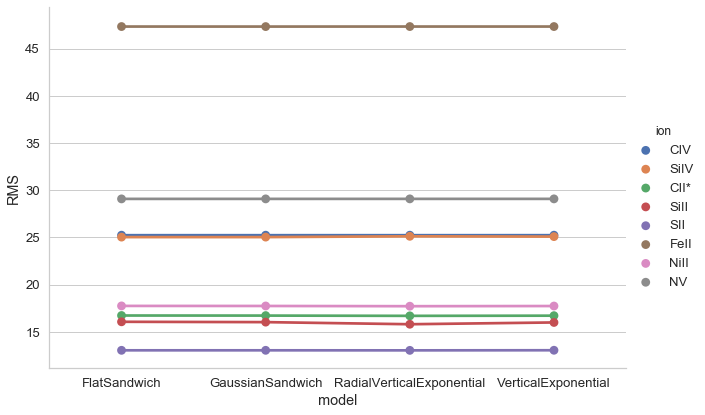

In [246]:
# cp.xlabel(fontsize=20)
# sns.set_style("white")
# sns.set(font_scale=1)
sns.set(style="whitegrid", font_scale=1.2)
# fig, ax = plt.subplots()

# sns.catplot(x="model", y="RMS", hue="ion",
#             palette={"male": "g", "female": "m"},
#             markers=["^", "o"], linestyles=["-", "--"],
#             kind="point", data=runs)

# plt.figure(figsize = (15,8))

cp = sns.catplot(x="model", y="RMS", hue="ion",
            kind="point", data=pd_runs,
            height=6,aspect=1.5)
ax.set_xlabel('X_axis',fontsize=20);